In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# import Libraries
import pandas as pd

import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from IPython.display import FileLink, FileLinks
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
sales_train_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/sales_train.csv")
sales_test_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/sales_test.csv")
calender_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/calendar.csv")
inventory_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/inventory.csv")
test_weights_df = pd.read_csv("rohlik-sales-forecasting-challenge-v2/test_weights.csv")

In [4]:
sales_train_df.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


In [5]:
sales_test_df.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1226,2024-06-11,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
2,1226,2024-06-13,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
3,1226,2024-06-15,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0
4,1226,2024-06-09,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
calender_df.head()

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2


In [7]:
inventory_df.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


In [8]:
test_weights_df.head()

,unique_id,weight
0,0,2.535369
1,1,3.888933
2,2,5.885237
3,3,2.139552
4,5,3.021715


In [9]:
# Merge data
train_df = sales_train_df.merge(inventory_df, on=['unique_id', 'warehouse'], how='left')
train_df = train_df.merge(calender_df, on=['date', 'warehouse'], how='left')

train_df.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0


In [10]:
test_df = sales_test_df.merge(inventory_df, on=['unique_id', 'warehouse'], how='left')
test_df = test_df.merge(calender_df, on=['date', 'warehouse'], how='left')
test_df.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,...,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,...,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,NaN,0,0,0,0
1,1226,2024-06-11,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,...,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,NaN,0,0,0,0
2,1226,2024-06-13,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,...,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,NaN,0,0,0,0
3,1226,2024-06-15,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,...,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,NaN,0,0,0,0
4,1226,2024-06-09,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,...,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,NaN,0,0,0,0


In [11]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [12]:
for df in [train_df, test_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)

# Exploring Data

In [13]:
train_df.columns

Index(['unique_id', 'date', 'warehouse', 'total_orders', 'sales',
       'sell_price_main', 'availability', 'type_0_discount', 'type_1_discount',
       'type_2_discount', 'type_3_discount', 'type_4_discount',
       'type_5_discount', 'type_6_discount', 'product_unique_id', 'name',
       'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en',
       'L4_category_name_en', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'year', 'month', 'day',
       'dayofweek', 'is_weekend'],
      dtype='object')

In [14]:
# from ydata_profiling import ProfileReport
# reports = ProfileReport(train_df, minimal = True)
# reports.to_file("reports.html")
# display(reports)

In [15]:
train_df.isna().sum()

unique_id                       0
date                            0
warehouse                       0
total_orders                   52
sales                          52
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_name_en             0
holiday_name              3844119
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
year                            0
month                           0
day                             0
dayofweek                       0
is_weekend    

In [16]:
train_df['total_orders'].fillna(train_df['total_orders'].mean(), inplace = True)
test_df['total_orders'].fillna(test_df['total_orders'].mean(), inplace = True)
train_df['sales'].fillna(train_df['sales'].mean(), inplace = True)

train_df['holiday_name'].fillna( "No Holiday", inplace = True)
test_df['holiday_name'].fillna("No Holiday", inplace = True)

In [17]:
# train_df.isna().sum()

In [18]:
train_df.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,dayofweek,is_weekend
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,No Holiday,0,0,0,0,2024,3,10,6,1
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,No Holiday,0,0,0,0,2021,5,25,1,0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,No Holiday,0,0,0,0,2021,12,20,0,0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,No Holiday,0,0,0,0,2023,4,29,5,1
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,No Holiday,0,0,0,0,2022,4,1,4,0


# Interpreting Data
1. 23 columns with 4007419 rows.
2. 16 numerical value, 10 categorical values and 3 text variables.
3. Missing values present in total_orders, sales and holiday_name.
4. Target is to forecast sales column for a given id constructed from unique_id and date.
5. 1402 unique dates and 5390 distinct unique_id observed.
6. Data for 7 distinct warehouses.
7. Availablity (not provided in test data) is 1, 75% of the time.
8. Sales is the target variable with 49207 zeros.

In [19]:
train_df = train_df.drop("availability", axis = 1)

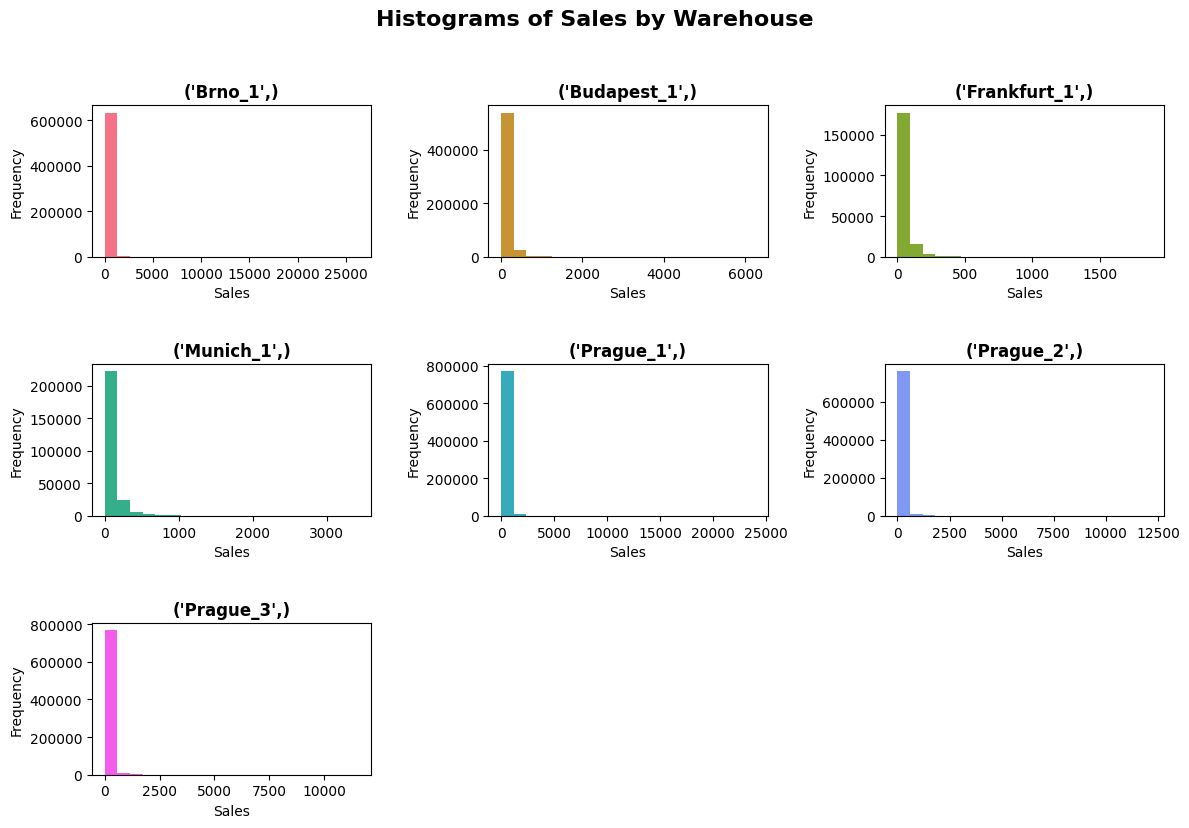

In [20]:
# Exploring sales for each warehouse

palette = sns.color_palette("husl", len(train_df['warehouse'].unique()))

# Create a figure for subplots
plt.figure(figsize=(12, 8))

# Loop through the grouped data
for i, (combi, df) in enumerate(train_df.groupby(['warehouse'], observed=False)):
    ax = plt.subplot(3, 3, i + 1)
    ax.hist(df['sales'], bins=20, color=palette[i])  # Use unique color for each warehouse
    ax.set_title(combi, fontweight='bold')
    ax.set_xlabel('Sales')
    ax.set_ylabel('Frequency')

# Add an overall title and adjust layout
plt.suptitle('Histograms of Sales by Warehouse', y=1.03, fontsize=16, fontweight='bold')
plt.tight_layout(h_pad=3.0)
plt.show()

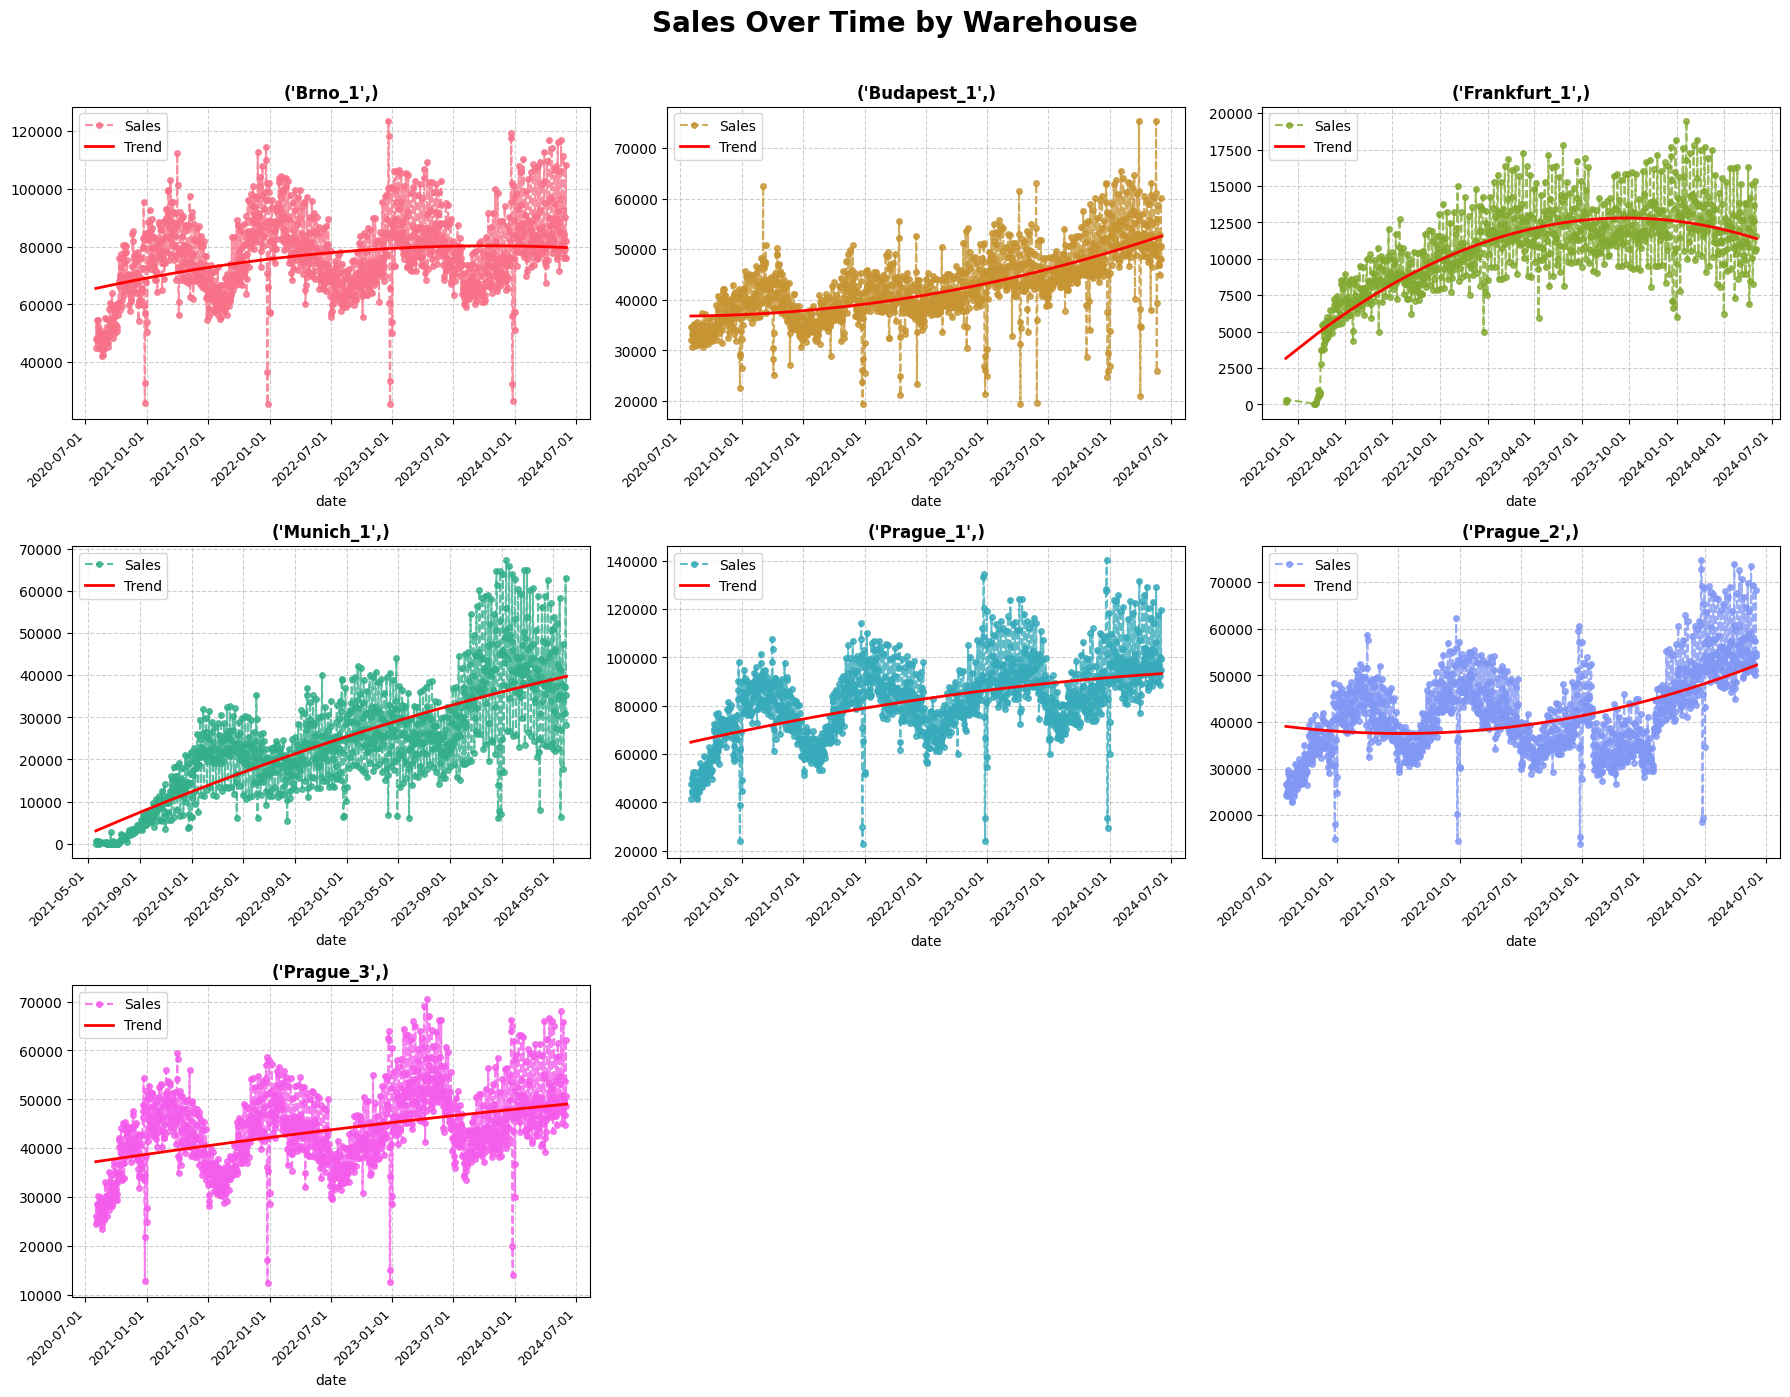

In [21]:
# Use polynomial regression for sales at each warehouse

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import datetime as dt

plt.figure(figsize=(18, 30))
palette = sns.color_palette("husl", n_colors=len(train_df['warehouse'].unique()))

# Loop through each warehouse
for i, (comb, df) in enumerate(train_df.groupby(['warehouse'], observed=False)):
    ax = plt.subplot(7, 3, i + 1) 
    
    # Prepare data
    sales = df.sort_values(by='date').groupby('date')['sales'].sum().reset_index()
    trend = (sales.date - sales.iloc[0].date) // dt.timedelta(days=1)
    trend = trend.values.reshape(-1, 1)
    
    # Polynomial regression for trend
    model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    model.fit(trend, sales.sales)
    y_pred = pd.Series(model.predict(trend), index=sales.date)
    
    # Plot sales and trend
    sales_color = palette[i]  # Assign unique color to each warehouse
    ax.plot(sales.date, sales.sales, label='Sales', color=sales_color, marker='o', markersize=4, ls='--', alpha=0.8)
    y_pred.plot(ax=ax, color='red', label='Trend', linewidth=2)
    
    # Customize plot appearance
    ax.set_title(comb, fontsize=12, fontweight='bold')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=9)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    
# Overall title and layout
plt.tight_layout()
plt.suptitle('Sales Over Time by Warehouse', fontsize=20, y=1.02, fontweight='bold')
plt.show()

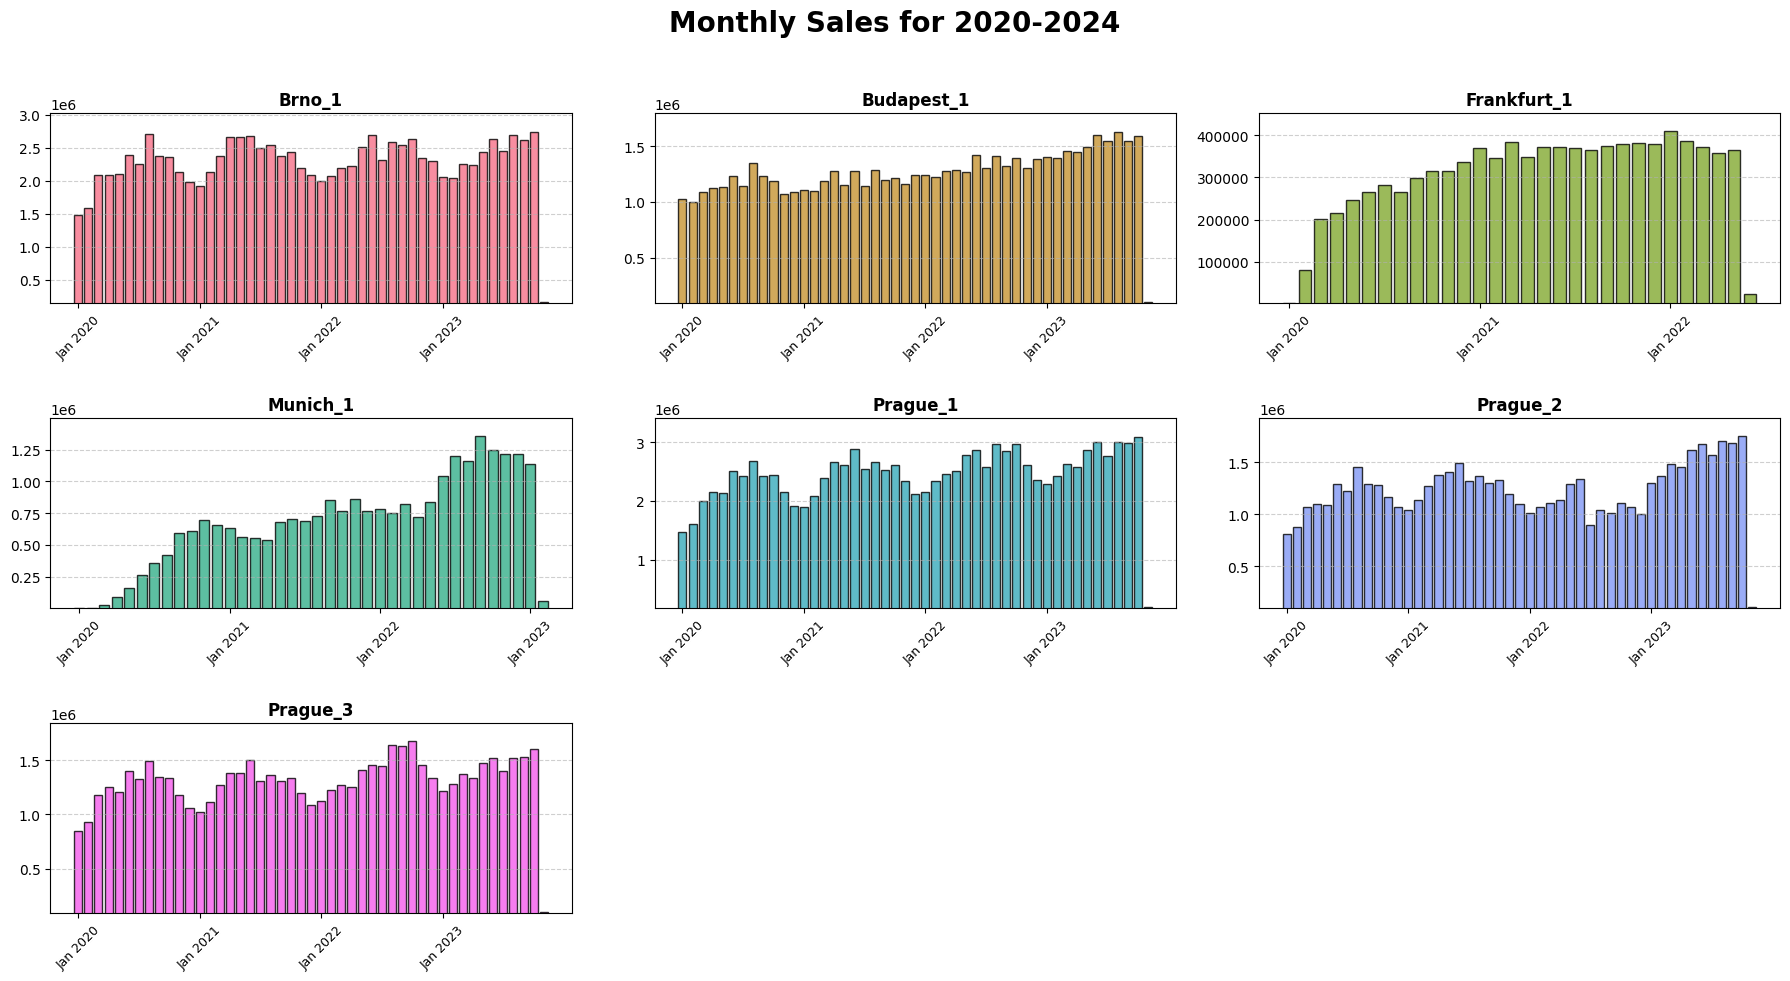

In [22]:
# Visualize monthly sales for each warehouse

plt.figure(figsize=(18, 12))
palette = sns.color_palette("husl", n_colors=len(train_df['warehouse'].unique()))

# Loop through each warehouse
for i, (comb, df) in enumerate(train_df.groupby(train_df.warehouse, observed=False)):    
    ax = plt.subplot(4, 3, i + 1, ymargin=0.5)
    
    # Resample sales data
    
    groupedM = df.groupby(['year', 'month'])['sales'].sum()
    bar_colors = [palette[i]] * len(groupedM)  # Unique color for each warehouse
    
    # Plot bars
    ax.bar(range(len(groupedM)), groupedM, color=bar_colors, alpha=0.8, edgecolor="black")
    
    # Customize plot appearance
    ax.set_title(comb, fontsize=12, fontweight='bold')
    ax.set_ylim(groupedM.min() * 0.9, groupedM.max() * 1.1)  # Add y-axis padding
    
    # Get the correct range of years for tick labels
    xticks = range(0, len(groupedM), 12)
    xticklabels = [f"Jan {y}" for y in range(2020, 2020 + len(xticks))]  # Dynamically generate labels
    
    ax.set_xticks(xticks)  # Set tick positions
    ax.set_xticklabels(xticklabels, rotation=45, fontsize=9)  # Set tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Overall title and layout
plt.suptitle('Monthly Sales for 2020-2024', y=1.02, fontsize=20, fontweight='bold')
plt.tight_layout(h_pad=2.5, w_pad=1.5)
plt.show()

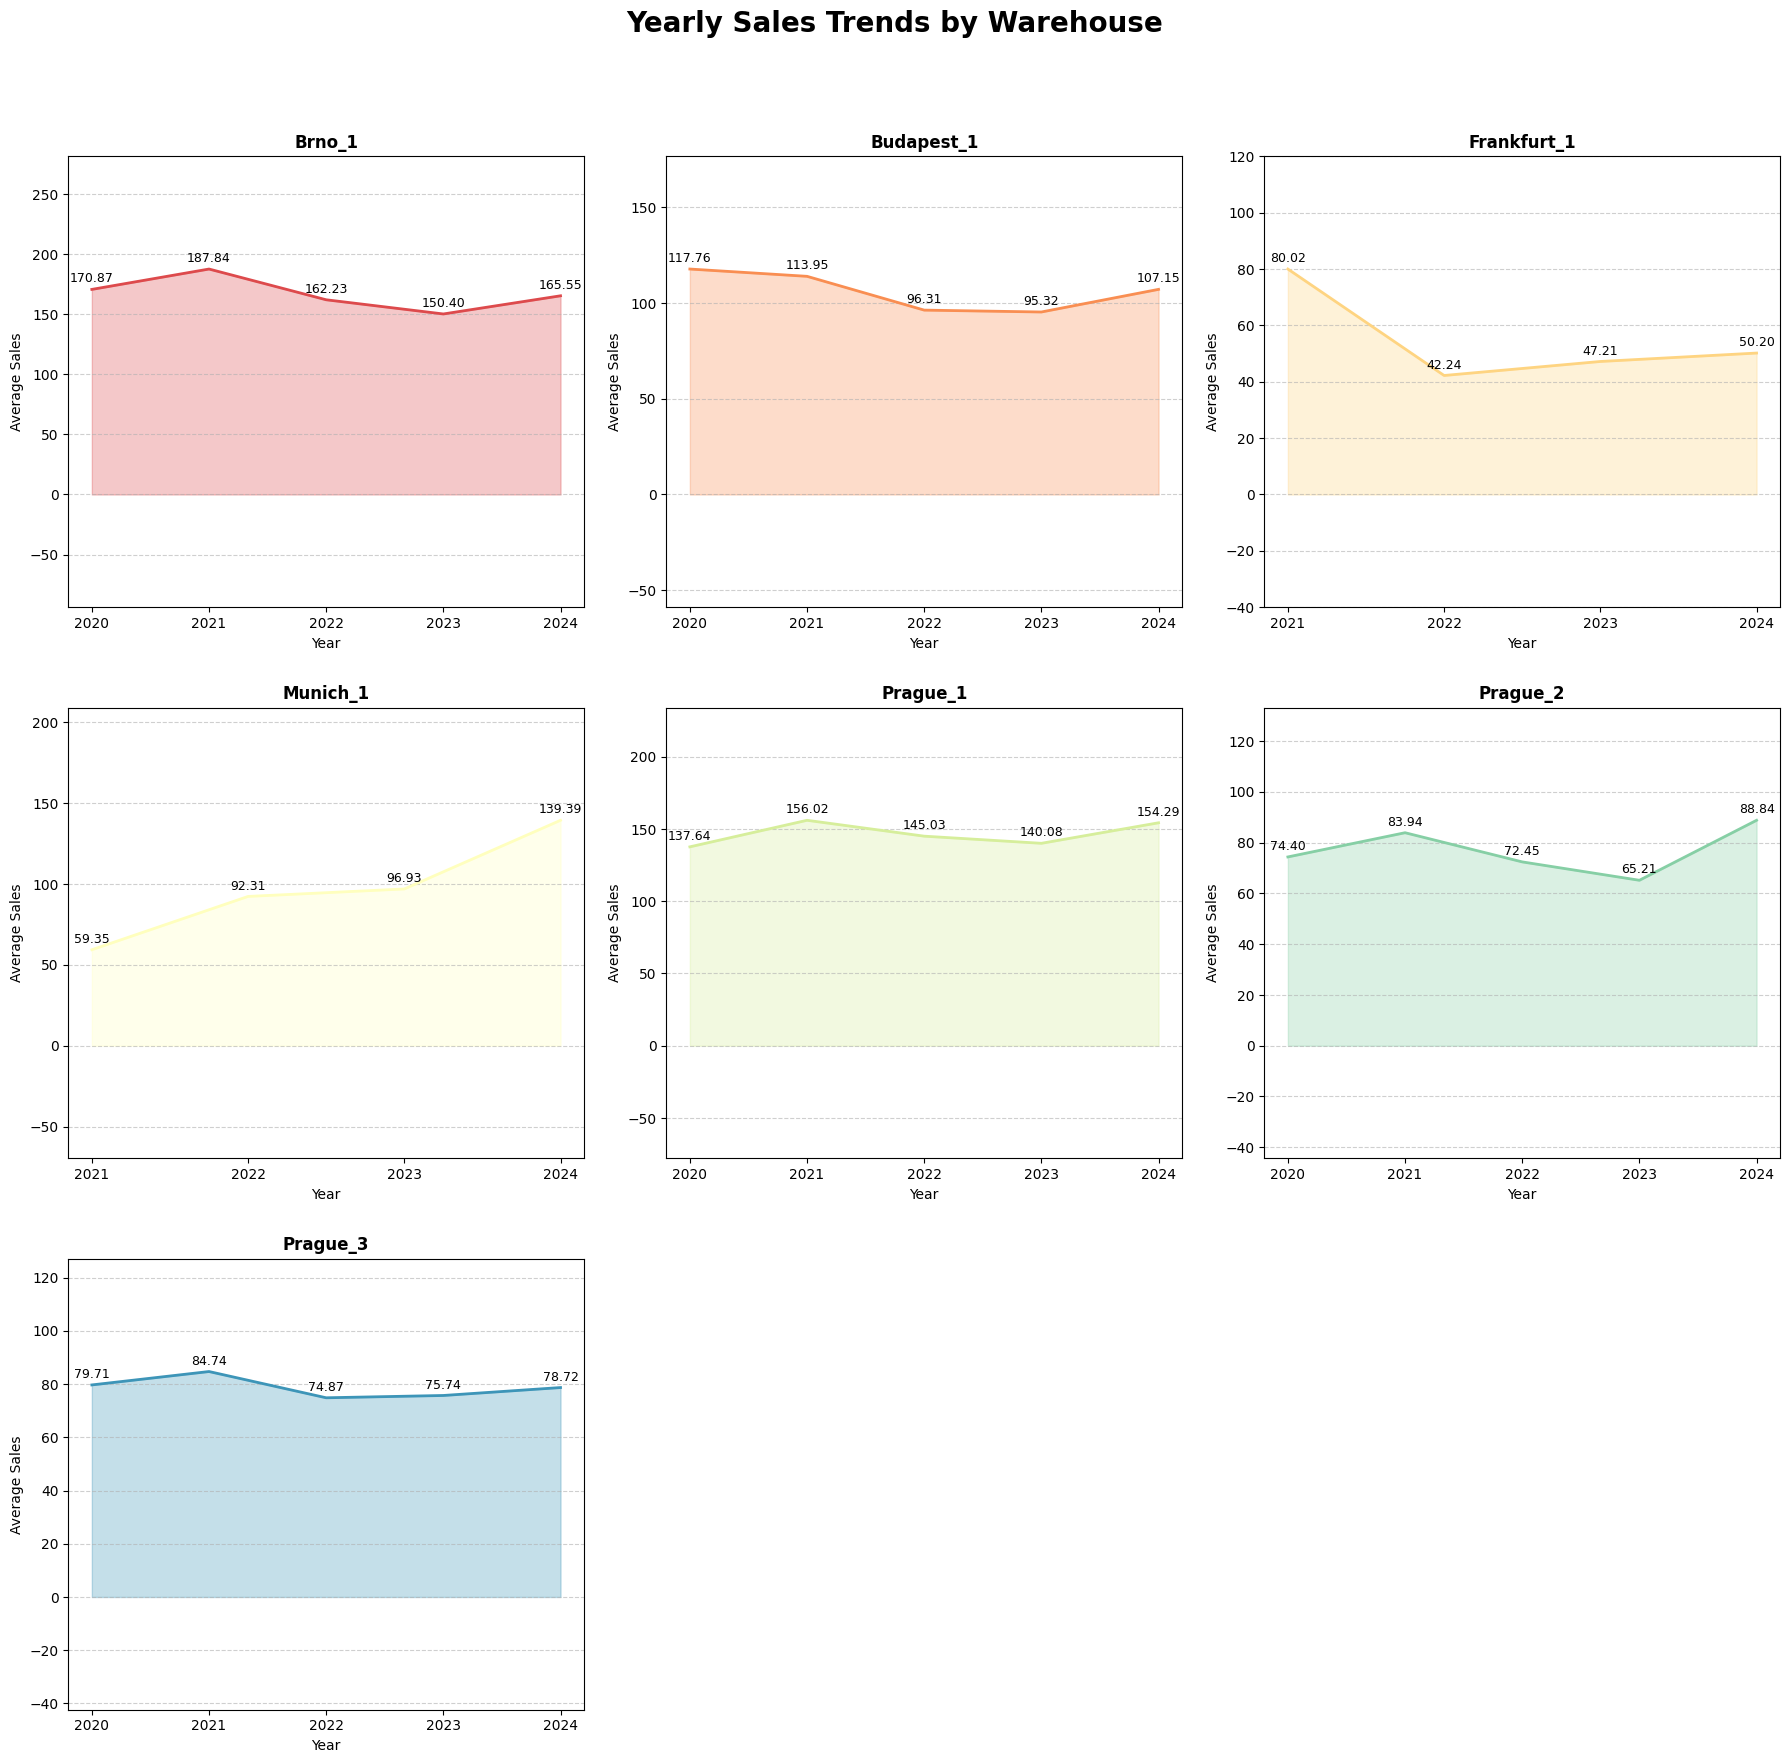

In [23]:
# visualize sales at each warehouse each year
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(18, 22))
palette = sns.color_palette("Spectral", n_colors=len(train_df['warehouse'].unique()))  # Unique color palette

# Loop through each warehouse
for i, (comb, df) in enumerate(train_df.groupby(train_df.warehouse, observed=False)):    
    ax = plt.subplot(4, 3, i + 1, ymargin=0.5)
    
    # Resample sales data by year
    resampled = df.groupby(['year'])[['sales']].mean().reset_index()
    
    # Plot line graph with shaded area
    ax.plot(resampled.year, resampled.sales, label='Yearly Avg Sales', color=palette[i], linewidth=2)
    ax.fill_between(resampled.year, resampled.sales, color=palette[i], alpha=0.3)
    
    # Set titles and axis labels
    ax.set_title(comb, fontsize=12, fontweight='bold')
    ax.set_xlabel("Year", fontsize=10)
    ax.set_ylabel("Average Sales", fontsize=10)
    
    # Annotate each year with the corresponding sales value
    for x, y in zip(resampled.year, resampled.sales):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-ticks are integers
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Overall title and layout
plt.suptitle('Yearly Sales Trends by Warehouse', y=1.03, fontsize=20, fontweight='bold')
plt.tight_layout(h_pad=2.5, w_pad=1.5)
plt.show()

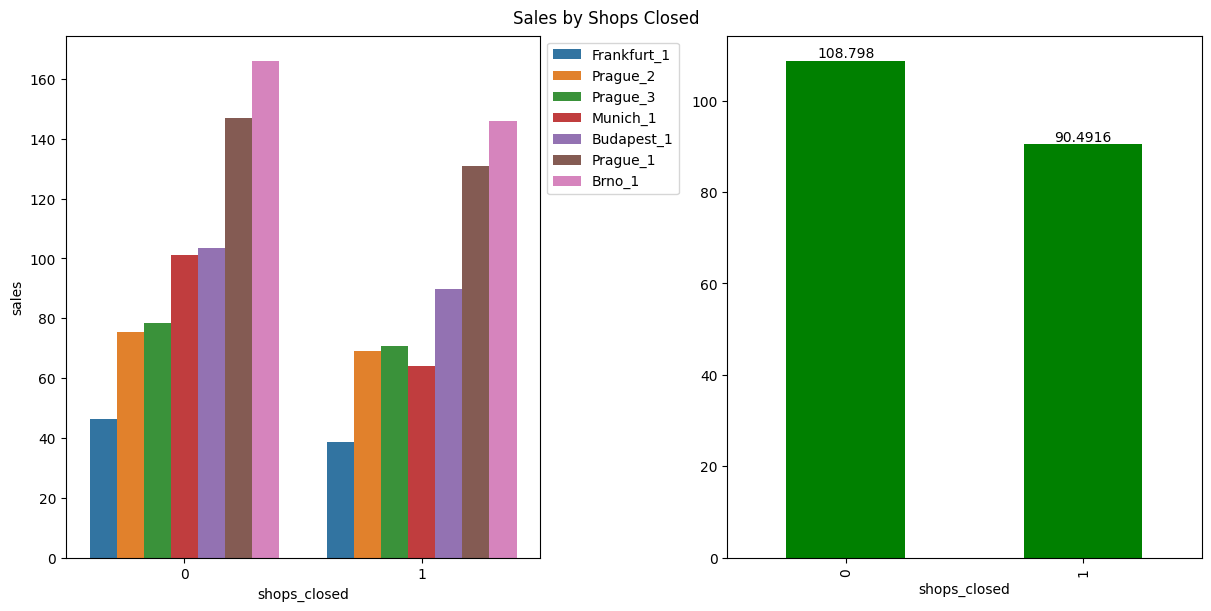

In [24]:
# Analyzing sales for shops closed

# Replace inf values with NaN to avoid the FutureWarning
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Group by and handle the 'observed' argument to avoid deprecation warning
mean_sales = train_df.groupby(['shops_closed', 'warehouse'], observed=True)['sales'].mean().reset_index().sort_values(by='sales')

# Create subplots
_, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
ax = axs.ravel()

# Plot bar plot with hue for warehouses
sns.barplot(data=mean_sales, x='shops_closed', y='sales', hue='warehouse', errorbar=None, ax=ax[0])
ax[0].legend(bbox_to_anchor=[1, 1])

# Plot bar plot for sales by 'shops_closed'
train_df.groupby(['shops_closed'])['sales'].mean().plot(kind='bar', ax=ax[1], color='green')
ax[1].bar_label(ax[1].containers[0])

# Set title
plt.suptitle('Sales by Shops Closed')

# Show the plot
plt.show()


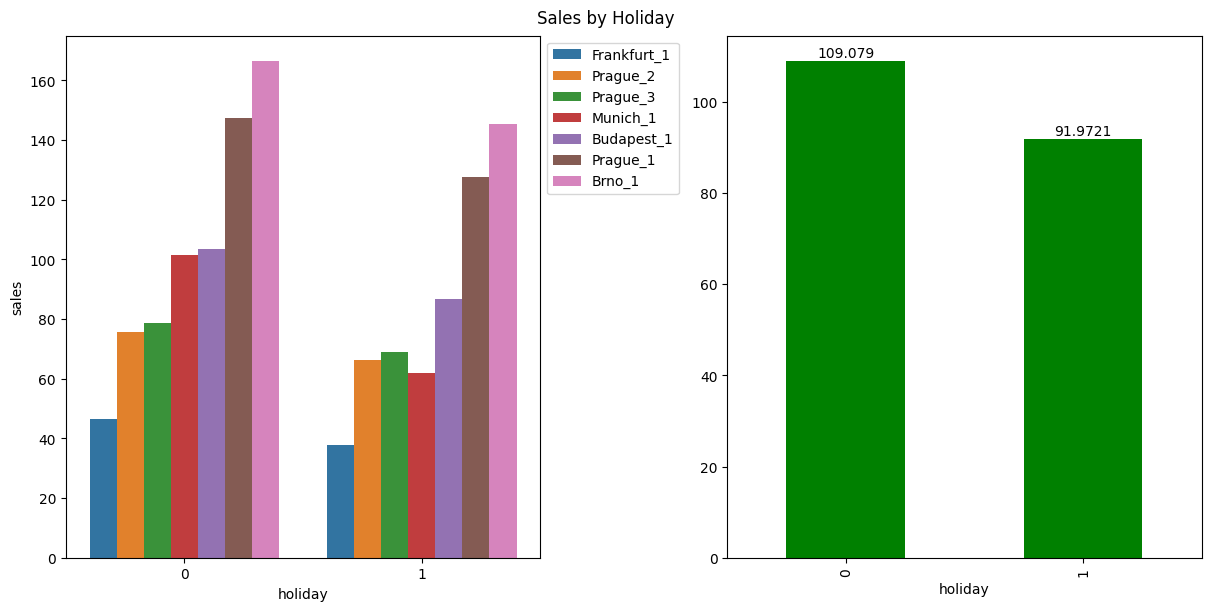

In [25]:
# Replace inf values with NaN to avoid the FutureWarning
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Group by and handle the 'observed' argument to avoid deprecation warning
sales_mean = train_df.groupby(['holiday', 'warehouse'], observed=True)['sales'].mean().reset_index().sort_values(by='sales')

# Create subplots
_, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
ax = axs.ravel()

# Plot bar plot with hue for warehouses
sns.barplot(data=sales_mean, x='holiday', y='sales', hue='warehouse', errorbar=None, ax=ax[0])
ax[0].legend(bbox_to_anchor=[1, 1])

# Plot bar plot for sales by 'shops_closed'
train_df.groupby(['holiday'])['sales'].mean().plot(kind='bar', ax=ax[1], color='green')
ax[1].bar_label(ax[1].containers[0])

# Set title
plt.suptitle('Sales by Holiday')

# Show the plot
plt.show()

In [26]:
from IPython.display import display

In [27]:
# Crosstab 1: Sales based on shops_closed and holiday
crosstab1 = pd.crosstab(index=train_df['shops_closed'], 
                         columns=train_df['holiday'], 
                         margins=False)

# Style for crosstab1 with background gradient and borders
styled_crosstab1 = crosstab1.style.background_gradient(axis=0, cmap='YlOrRd')\
                               .set_table_styles([{'selector': 'th', 'props': [('background-color', '#2b2b2b'), 
                                                                            ('color', 'white'), 
                                                                            ('font-weight', 'bold')]}])\
                               .set_caption('Sales Analysis: Shops Closed vs Holiday')

# Crosstab 2: Sales based on shops_closed, warehouse, and holiday
crosstab2 = pd.crosstab(index=[train_df['shops_closed'], train_df['warehouse']], 
                        columns=train_df['holiday'], 
                        margins=False)

# Style for crosstab2 with a different color map and bold text
styled_crosstab2 = crosstab2.style.background_gradient(axis=0, cmap='coolwarm')\
                               .set_table_styles([{'selector': 'th', 'props': [('background-color', '#4e4e4e'), 
                                                                            ('color', 'white'), 
                                                                            ('font-weight', 'bold')]}])\
                               .set_caption('Sales Analysis: Shops Closed, Warehouse vs Holiday')

# Display the styled crosstabs
display(styled_crosstab1)
display(styled_crosstab2)

holiday,0,1
shops_closed,,
0,3843953,72231
1,0,91235


In [28]:
# Replace inf values with NaN to avoid the FutureWarning
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [29]:
categorical_columns = ['warehouse', 'name', 'L1_category_name', 'L2_category_name', 'L3_category_name', 'holiday_name']
for col in categorical_columns:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)

In [30]:
train_df

,unique_id,date,warehouse,total_orders,sales,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,...,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,year,month,day,dayofweek,is_weekend
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,0.00000,0.0,0.0,0.0,...,No Holiday,0,0,0,0,2024,3,10,6,1
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,0.00000,0.0,0.0,0.0,...,No Holiday,0,0,0,0,2021,5,25,1,0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,0.00000,0.0,0.0,0.0,...,No Holiday,0,0,0,0,2021,12,20,0,0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.20024,0.0,0.0,0.0,...,No Holiday,0,0,0,0,2023,4,29,5,1
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,0.00000,0.0,0.0,0.0,...,No Holiday,0,0,0,0,2022,4,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4007414,4941,2023-06-21,Prague_1,9988.0,26.56,34.06,0.00000,0.0,0.0,0.0,...,No Holiday,0,0,0,0,2023,6,21,2,0
4007415,4941,2023-06-24,Prague_1,8518.0,27.42,34.06,0.00000,0.0,0.0,0.0,...,No Holiday,0,0,0,0,2023,6,24,5,1
4007416,4941,2023-06-23,Prague_1,10424.0,33.39,34.06,0.00000,0.0,0.0,0.0,...,No Holiday,0,0,0,0,2023,6,23,4,0
4007417,4941,2023-06-22,Prague_1,10342.0,22.88,34.06,0.00000,0.0,0.0,0.0,...,No Holiday,0,0,0,0,2023,6,22,3,0


In [31]:
# form dataframe for weight for all unique ids
y_weight = pd.DataFrame([np.nan]*5432)
for i in range(0, len(test_weights_df)):
    u = test_weights_df['unique_id'].iloc[i]
    y_weight.iloc[u] = test_weights_df['weight'].iloc[i]

In [32]:
missing = np.where(y_weight.isna())
missing[0]

array([   4,  380,  381,  382,  397,  716,  823,  837,  838,  839, 1220,
       1317, 1701, 1702, 1703, 1704, 2040, 2288, 2298, 2658, 2659, 2660,
       3171, 3172, 3174, 3256, 3352, 3435, 3812, 3963, 4184, 4317, 4386,
       4387, 4388, 4389, 4456, 4851, 4939, 4943, 5136, 5334], dtype=int64)

In [ ]:
training_weights_df = train_df.copy()
training_weights_df = training_weights_df.groupby(['unique_id'])

In [ ]:
training_weights_df.head()

# Modelling

In [ ]:
train_df_copy = train_df.copy()
train_df_copy.reset_index().plot.scatter(x = 'index', y = 'sales')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [ ]:
X = train_df.drop('sales', axis = 1)
y = train_df.sales

In [ ]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
# building Random forest regressor model
rfc = RandomForestClassifier()

In [ ]:
# Init GridSearchCV() object and fitting it with hyperparameters

forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='r2')
clf.fit(X_train, y_train)

In [ ]:
print(clf.best_params_)
print(clf.best_score_)